<a href="https://colab.research.google.com/github/stiepan/MLCourse/blob/master/Linear_regression_L1E2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression 

In this exercise you will use linear regression to predict flat prices. One more time, training will be handled via gradient descent. Although, contratry to the first exercise, we will now:
* have multiple features (i.e. variables used to make the prediction),
* employ some basic feature engineering,
* work with a different loss function.

Let's start with getting the data.

In [1]:
%matplotlib inline

!wget -O mieszkania.csv https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
!wget -O mieszkania_test.csv https://www.dropbox.com/s/dbrj6sbxb4ayqjz/mieszkania_test.csv?dl=1

--2020-03-21 20:33:47--  https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/zey0gx91pna8irj/mieszkania.csv [following]
--2020-03-21 20:33:47--  https://www.dropbox.com/s/dl/zey0gx91pna8irj/mieszkania.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd93e8d5a1a4147b19158371972.dl.dropboxusercontent.com/cd/0/get/A0XY7RlsFHboWjTsUJx31HGCZImsXGiboskUcPe8M6xY62rEtz0h8aUjhY649_RQ5EWLLMNDp7FUygDVCFII3lQiYfSTseOnQTVfExc9uZ1C3g/file?dl=1# [following]
--2020-03-21 20:33:47--  https://ucd93e8d5a1a4147b19158371972.dl.dropboxusercontent.com/cd/0/get/A0XY7RlsFHboWjTsUJx31HGCZImsXGiboskUcPe8M6xY62rEtz0h8aUjhY649_RQ5EWLLMNDp7FUygDVCFII3lQiYfSTseOnQTVfExc9uZ1C3g/file?dl=1
Resolv

In [2]:
!head mieszkania.csv mieszkania_test.csv

==> mieszkania.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
104,mokotowo,2,2,1940,1,780094
43,ochotowo,1,1,1970,1,346912
128,grodziskowo,3,2,1916,1,523466
112,mokotowo,3,2,1920,1,830965
149,mokotowo,3,3,1977,0,1090479
80,ochotowo,2,2,1937,0,599060
58,ochotowo,2,1,1922,0,463639
23,ochotowo,1,1,1929,0,166785
40,mokotowo,1,1,1973,0,318849

==> mieszkania_test.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
71,wolowo,2,2,1912,1,322227
45,mokotowo,1,1,1938,0,295878
38,mokotowo,1,1,1999,1,306530
70,ochotowo,2,2,1980,1,553641
136,mokotowo,3,2,1939,1,985348
128,wolowo,3,2,1983,1,695726
23,grodziskowo,1,1,1975,0,99751
117,mokotowo,3,2,1942,0,891261
65,ochotowo,2,1,2002,1,536499


Each row in the data represents a separate property. Our goal is to use the data from `mieszkania.csv` to create a model that can predict a property's price (i.e. `cena`) given its features (i.e. `m2,dzielnica,ilosc_sypialni,ilosc_lazienek,rok_budowy,parking_podziemny`). 

From now on, we should interfere only with `mieszkania.csv` (dubbed the training dataset) to make our decisions and create the model. The (only) purpose of `mieszkania_test.csv` is to test our model on **unseen** data.

Our predictions should minimize the so-called mean squared logarithmic error:
$$
MSLE = \frac{1}{n} \sum_{i=1}^n (\log(1+y_i) - \log(1+p_i))^2,
$$
where $y_i$ is the ground truth, and $p_i$ is our prediction.

Let's start with implementing the loss function.

In [0]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

# distances

def mse(ys, ps):
    ys = np.array(ys)
    ps = np.array(ps)
    return np.linalg.norm(ys - ps) / np.sqrt(len(ys)) #**2

def msle(ys, ps):
    ys = np.log(1 + np.array(ys))
    ps = np.log(1 + np.maximum(-0.999, np.array(ps)))
    return np.linalg.norm(ys - ps) / np.sqrt(len(ys)) #**2

The simplest model is predicting the same constant for each instance. Test your implementation of msle against outputing the mean price.

In [4]:
ms = pandas.read_csv('mieszkania.csv')
avg_price = np.mean(ms.cena)
avg_mse = mse(ms.cena, [avg_price] * len(ms.cena))
avg_msle = msle(ms.cena, [avg_price] * len(ms.cena))
print(avg_price, avg_mse, avg_msle)

507919.49 271680.6977271479 0.6257198684920441


Recall that outputing the mean minimzes $MSE$. However, we're now dealing with $MSLE$.

Think of a constant that should result in the lowest $MSLE$.

In [5]:
best_c_msle = np.power(np.e, np.mean(np.log(ms.cena + 1))) - 1
c_msle_mse = mse(ms.cena, [best_c_msle] * len(ms.cena))
c_msle_msle = msle(ms.cena, [best_c_msle] * len(ms.cena))
print(best_c_msle, c_msle_mse, c_msle_msle)

431435.49158234015 282241.39230712154 0.6040609341890592


Now, let's implement a standard linear regression model. 

In [0]:
# data preparation

class PrepData(object):
    
    def __init__(
        self, frame, predict, dummies=None,
        scale=None, scale_ys=True, reference=None,
        log_ys=False,
    ):
        if dummies is None:
            dummies = []
        if reference is None:
            reference = {}
        
        self.predict = predict
        self.dummies = dummies
        self.reference = reference
        
        self.ys_ = np.array(frame[predict])
        if log_ys:
          self.ys_ = np.log(1 + self.ys_)
        
        if not scale_ys:
            self.ys_min = 0.
            self.ys_max = 1.
        else:
            self.ys_min = min(self.ys_)
            self.ys_max = max(self.ys_)
        self.ys = (self.ys_ - self.ys_min)/(self.ys_max - self.ys_min)
        
        self.n = len(self.ys)  # number of samples
        assert(self.n > 0)
        frame = frame.drop(columns=predict)
        
        frame = self.get_dummies(frame, dummies, reference)
        
        if scale is None:
            scale = frame.columns
        self.scale_factors = [
            (c, min(frame[c]), max(frame[c])) for c in scale
        ]
        frame = self.scale_frame(frame, self.scale_factors)
        
        columns = frame.columns
        xs = frame.values
        self.xs = np.c_[np.ones(self.n), xs]
        self.columns = ['Intercept'] + list(columns)
        self.m = len(self.xs[0])  # number of features
    
    @classmethod
    def get_dummies(cls, frame, dummies, reference):
        for dummy in dummies:
            dummies_cols = pandas.get_dummies(frame[dummy])
            # one of the categories should be dropped to avoid 
            # perfectly lineary dependent columns in the model
            # (is this any trouble for gradient descent though?)
            drop = reference.get(dummy, dummies_cols.columns[-1])
            dummies_cols = dummies_cols.drop(columns=drop)
            frame = frame.join(dummies_cols)
            frame = frame.drop(columns=dummy)
        return frame
    
    @classmethod
    def scale_frame(cls, frame, scales):
        return frame.assign(**{
            c: (frame[c] - mn)/(mx - mn)
            for c, mn, mx in scales
        })
    
    def test_data(self, frame):
        if self.predict in frame.columns:
            frame.drop(columns=self.predict)
        frame = self.get_dummies(frame, self.dummies, self.reference)
        fcs = frame.columns
        for c in self.columns:
            if c not in fcs:
                frame[c] = 1 if c == 'Intercept' else 0
        frame = frame[self.columns]
        frame = self.scale_frame(frame, self.scale_factors)
        return frame.values
    
    def inflate_ys(self, ys):
        return ys * (self.ys_max - self.ys_min) + self.ys_min



class Training(object):

    """Results of training on particual data using particular method"""
    
    def __init__(self, ws, losses, trainer):
        self.ws = ws
        self.losses = losses
        self.trainer = trainer
        self.prep_data = trainer.prep_data
    
    def plot(self, *args, **kwargs):
        plt.plot(self.losses, *args, **kwargs)
    
    def train_error(self):
        return self.losses[-1]
    
    def error(self, l=None, xs=None):
        return self.trainer.evaluate(self.ws, xs, l)
    
    def test_error(self, l, frame):
        xs = self.prep_data.test_data(frame)
        return self.error(l, xs)
    
    def coefs(self):
        return ((coef, w) for coef, w in zip(self.prep_data.columns, self.ws))



class LRGradDesc(object):

    """Performs linear reg. using grad descent"""
    
    def __init__(self, prep_data, loss=None, grad=None):
        self.loss = loss or mse
        self.grad = grad or Gradient.get('mse')        
        self.prep_data = prep_data

    def train(self, n_epochs=100, l_rate=None, ws=None, r_start=None):
        ys = self.prep_data.ys
        if l_rate is None:
            l_rate = self.l_rate_of_mean(ys)
        
        if ws is None:
            m = self.prep_data.m
            if r_start is None:
                ws = np.array([0.] + [1.] * (self.prep_data.m - 1))
            else:
                ws = np.array([
                    float(random.randint(-r_start, r_start)) for _ in range(0, m)
                ])
        losses = []
        xs = self.prep_data.xs
        for i in range(n_epochs):
            ws -= l_rate * self.grad(ws, ys, xs)
            losses.append(self.evaluate(ws))
        return Training(ws, losses, self)

    def evaluate(self, ws, xs=None, l=None):
        return (l or self.loss)(self.prep_data.ys_, self.predict(ws, xs))
    
    def predict(self, ws, xs=None):
        pred = np.dot(xs if xs is not None else self.prep_data.xs, ws)
        return self.prep_data.inflate_ys(pred)
    
    @classmethod
    def l_rate_of_mean(cls, ys):
        return 0.1 * 10**(-np.ceil(np.log10(np.mean(ys))))


class Gradient(object):

    """Available gradients"""
    
    @classmethod
    def get(cls, name):
        return getattr(cls(), name)

    def mse(self, ws, ys, xs):
        pred = np.dot(xs, ws)
        df_t = np.transpose(ys - pred)
        return np.dot(df_t, xs) * (-2.) / len(ys)

    def msle(self, ws, ys, xs):
        pred_1 = np.dot(xs, ws) + 1
        df_t = np.transpose(np.log(1 + ys) - np.log(pred_1))
        innerd = np.dot(np.diag(1. / pred_1), xs)
        return np.dot(df_t, innerd) * (-2.) / len(ys)


class ExactMSEReg(object):

    """'Exact' linear regression"""
    
    def __init__(self, prep_data):
        self.prep_data = prep_data
    
    def train(self, ridge=None):
        x = self.prep_data.xs
        ys = self.prep_data.ys
        x_t = np.transpose(x)
        x_t_x = np.dot(x_t, x)
        if ridge is not None:
            n = len(x_t_x)
            x_t_x += n * ridge * np.identity(n)
        ws = np.linalg.solve(x_t_x, np.dot(x_t, ys))
        losses = [self.evaluate(ws)]
        return Training(ws, losses, self)
    
    def evaluate(self, ws, xs=None, l=None):
        return (l or mse)(self.prep_data.ys_, self.predict(ws, xs))
    
    def predict(self, ws, xs=None):
        pred = np.dot(xs if xs is not None else self.prep_data.xs, ws)
        return self.prep_data.inflate_ys(pred)


Intercept 0.5011532720124918 0.5055863890999448
xs 0.29242390472111224 0.284655907590917


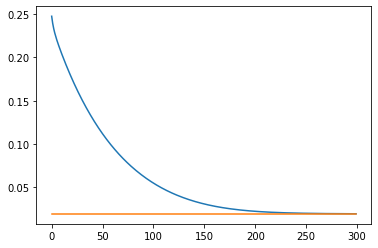

In [7]:
# first, let's look at the toy example from previous lecture as 
# sanity check form the code

import random

m = 2 # features
n = 50 # number of examples

_a = 0.3
_b = 0.5

f = lambda x: _a * x + _b # ground truth
g = lambda x: f(x) + random.gauss(0, 0.02) # a noisy version of f

toy_xs = [random.random() for _ in range(n)] # features
toy_ys = list(map(g, toy_xs)) # targets

toy_ts = list(map(f, toy_xs)) # we don't get to see this

toy_data = pandas.DataFrame(np.c_[toy_xs, toy_ys])
toy_data.columns = ('xs', 'ys',)

# toy example numeric descend

n_epochs = 300

toy_pdata = PrepData(toy_data, 'ys', scale_ys=False)

toy_desc = LRGradDesc(toy_pdata, mse, Gradient.get('mse'))
toy_desc_r = toy_desc.train(n_epochs)
toy_desc_r.plot()

toy_exact = ExactMSEReg(toy_pdata).train()
plt.plot([toy_exact.error(mse)] * n_epochs)

for ((c, w), (_, ww)) in zip(toy_desc_r.coefs(), toy_exact.coefs()):
    print (c, w, ww)


62195.865627280815 62195.865622777346 

Intercept 0.07351355467721402 0.07351216255841564
m2 0.8723664973929199 0.872375878083021
ilość_sypialni -0.012829573049500777 -0.012834233656186224
ilość_łazienek -0.02751310931477963 -0.027516536594948703
rok_budowy 0.021939127733718627 0.021939490156789244
parking_podziemny 0.024556024331221307 0.024556174519774265
grodziskowo -0.23990321202855414 -0.23990335669263907
mokotowo -0.00553240207699417 -0.005532406406839382
wolowo -0.16744150275488692 -0.16744156133033614

 378260.2024091535


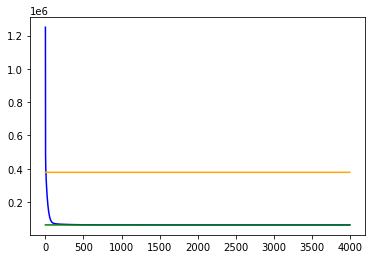

In [8]:
# ok, mse regression for the data eventually

epochs=4000

ms = pandas.read_csv('mieszkania.csv')
ms_d = PrepData(ms, 'cena', ('dzielnica',), reference={'dzielnica': 'ochotowo'})


# gradietn descent (mse)
l_mse_a = LRGradDesc(ms_d, mse, Gradient.get('mse'))
l_mse_a_r = l_mse_a.train(epochs, 0.3)
l_mse_a_r.plot(color='blue')


# mse optimized with explicit formula
l_mse_exact = ExactMSEReg(ms_d).train()
plt.plot([l_mse_exact.error(mse)] * epochs, color='green')


# compare results
print(l_mse_a_r.error(mse), l_mse_exact.error(mse), "\n")
for ((c, dw), (_, aw)) in zip(l_mse_a_r.coefs(), l_mse_exact.coefs()):
    print (c, dw, aw)


# check with test data
ms_tst = pandas.read_csv('mieszkania_test.csv')
l_mse_a_r_t = l_mse_a_r.test_error(mse, ms_tst)
plt.plot([l_mse_a_r_t] * epochs, color='orange')
print("\n", l_mse_a_r_t)

Note that the loss function that the algorithms optimizes (i.e $MSE$) differs from $MSLE$. We've already seen that this may result in a suboptimal solution.

How can you change the setting so that we optimze $MSLE$ instead?

Hint: 
<sub><sup><sub><sup><sub><sup>
Be lazy. We don't want to change the algorithm.
</sup></sub></sup></sub></sup></sub>

0.2242123935551023 76468.77857192402 0.17391518980528248
0.8490476670493459 0.8297505990676357 

Intercept 0.12740312988311245 0.2738848915194801
m2 0.3709492540754932 0.8980895621027163
ilość_sypialni 0.22204476626978564 -0.011972822112291715
ilość_łazienek 0.1463211326481923 -0.10812386529926177
rok_budowy 0.007395515757821627 0.0053005335305156935
parking_podziemny 0.01750944703240785 0.012263741604246873
grodziskowo -0.18773827280084596 -0.19631431190636803
mokotowo 0.006525927879756269 0.0028067419114249873
wolowo -0.12348264424911318 -0.11531845688030862


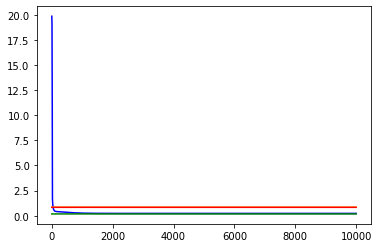

In [9]:
epochs=10000

ms = pandas.read_csv('mieszkania.csv')
ms_d = PrepData(ms, 'cena', ('dzielnica',), reference={'dzielnica': 'ochotowo'})

msle_a = LRGradDesc(ms_d, msle, Gradient.get('msle'))
msle_r = msle_a.train(epochs, 0.005, ws=[-0.1] * ms_d.m)
msle_r.plot(color='blue')

# msle optimized with explicit formula for mse (fitting linear model to log(1+yi))
ms_d_log = PrepData(ms, 'cena', ('dzielnica',), reference={'dzielnica': 'ochotowo'}, log_ys=True)
l_mlse_exact = ExactMSEReg(ms_d_log).train()
plt.plot([l_mlse_exact.error(mse)] * epochs, color='green')

print(msle_r.train_error(), msle_r.error(mse), l_mlse_exact.error(mse))

ms_tst = pandas.read_csv('mieszkania_test.csv')
msle_r_t = msle_r.test_error(msle, ms_tst)
plt.plot([msle_r_t] * epochs, color='orange')
l_mlse_exact_t = l_mlse_exact.test_error(mse, ms_tst)
plt.plot([l_mlse_exact_t] * epochs, color='red')
print(msle_r_t, l_mlse_exact_t, "\n")

for ((c, dw), (_, ew)) in zip(msle_r.coefs(), l_mlse_exact.coefs()):
    print (c, dw, ew)

Without any feature engineering our model approximates the price as a linear combination of original features:
$$
\text{price} \approx w_1 \cdot \text{area} + w_2 \cdot \text{district} + \dots.
$$
Let's now introduce some interactions between the variables. For instance, let's consider a following formula:
$$
\text{price} \approx w_1 \cdot \text{area} \cdot \text{avg. price in the district per sq. meter} + w_2 \cdot \dots + \dots.
$$
Here, we model the price with far greater granularity, and we may expect to see more acurate results.

Add some feature engineering to your model. Be sure to play with the data and not with the algorithm's code. 

Think how to make sure that your model is capable of capturing the $w_1 \cdot \text{area} \cdot \text{avg. price...}$ part, without actually computing the averages.

Hint: 
<sub><sup><sub><sup><sub><sup>
Is having a binary encoding for each district and multiplying it by area enough?
</sup></sub></sup></sub></sup></sub>

Hint 2: 
<sub><sup><sub><sup><sub><sup>
Why not multiply everything together? I.e. (A,B,C) -> (AB,AC,BC).
</sup></sub></sup></sub></sup></sub>

0.20492495497437388 70449.86758460048 1.3450741510229471 61659.759404326294 0.0953958990810623 

0.8459741968267376 0.8426268755825546 

Intercept 0.12219801107326586 0.08726366420733025 0.12402732188734461
m2 0.20249660745370157 0.3949557297005503 4.274548385091718
ilość_sypialni 0.05266365648822798 -0.04592409052482991 -1.1660720084218783
ilość_łazienek 0.021820162261160483 -0.07900729374497305 -1.3101734314840496
rok_budowy 0.0038224165230403106 0.006142230470580491 -0.009630931673975442
parking_podziemny 0.006711524671977901 -0.046170969584674273 0.11580029781169134
m2_ilość_sypialni 0.10938229916274553 -0.03164134906390176 -1.6541207980004284
m2_ilość_łazienek 0.09133930111904533 0.15232381986910692 -1.176825414745587
m2_rok_budowy 0.20006701065837518 0.4293905567657737 -1.7652243545344382
m2_parking_podziemny 0.0482743008720307 -0.015019173860504999 -0.1193580440980915
ilość_sypialni_ilość_łazienek 0.02556464693439024 -0.0016311172943205934 2.060105027461669
ilość_sypialni_rok_bu

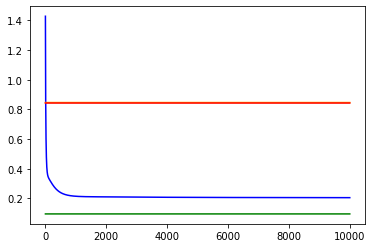

In [10]:
# product of all non-dummies
epochs=10000

ms = pandas.read_csv('mieszkania.csv')
ms_t = pandas.read_csv('mieszkania_test.csv')
columns = [c for c in ms.columns if c not in ['dzielnica', 'cena']]
for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        if j <= i:
            continue
        ms['{}_{}'.format(col1, col2)] = ms[col1] * ms[col2]
        ms_t['{}_{}'.format(col1, col2)] = ms_t[col1] * ms_t[col2]
ms_p = PrepData(ms, 'cena', ('dzielnica',), reference={'dzielnica': 'ochotowo'})

msle_p = LRGradDesc(ms_p, msle, Gradient.get('msle'))
msle_pr = msle_p.train(epochs, 0.005, ws=[0.] * ms_p.m)
msle_pr.plot(color='blue')

mse_p = LRGradDesc(ms_p, mse, Gradient.get('mse'))
mse_pr = mse_p.train(epochs, 0.2)
# mse_pr.plot(c='orange')


# msle optimized with explicit formula for mse (fitting linear model to log(1+yi))
ms_d_log = PrepData(ms, 'cena', ('dzielnica',), reference={'dzielnica': 'ochotowo'}, log_ys=True)
msle_p_exact = ExactMSEReg(ms_d_log).train()
plt.plot([msle_p_exact.error(mse)] * epochs, color='green')

print(msle_pr.train_error(), msle_pr.error(mse), mse_pr.error(msle), mse_pr.error(mse), msle_p_exact.error(mse), "\n")

msle_pr_t = msle_pr.test_error(msle, ms_t)
plt.plot([msle_pr_t] * epochs, color='orange')
msle_p_exact_t = msle_p_exact.test_error(mse, ms_t)
plt.plot([msle_p_exact_t] * epochs, color='red')
print(msle_pr_t, msle_p_exact_t, "\n")

for ((c, dw), (_, mw), (_, ew)) in zip(msle_pr.coefs(), mse_pr.coefs(), msle_p_exact.coefs()):
    print (c, dw, mw, ew)

0.10620941365515965 52259.8887693501 0.08392555883863528 28425.910982979985 0.10058764312750137 

0.8122715049448083 0.8375464576155802 

Intercept 0.022015749322114336 0.010793465396387397 0.04436320020188902
m2 0.19980177871406918 0.41986082042017847 2.906235823790145
ilość_sypialni 0.11652101268322718 0.022881107736049427 0.03201485926909825
ilość_łazienek 0.07493156232724205 0.005215118165973682 0.01597593035916931
rok_budowy -0.0010377685056922944 0.0054055773450434556 0.0010769439319686662
parking_podziemny 0.01140840034373933 0.01665486552332591 0.011875405992347233
logm2 0.19308844306442033 0.10704432497266472 0.4395139412073834
m2_logm2 0.20048161365439338 0.4695227011205492 -2.38949410095367
grodziskowo_avg -0.33791764093621357 -0.4797958326013058 -0.37174579458111534
mokotowo_avg 0.09790199501849726 -0.034963739561666714 -0.021589332970606886
wolowo_avg -0.1805299174160337 -0.31325473129408854 -0.19642973691469276
lazienki_i_sypialnie 0.09747925257011919 -0.02531500770652511

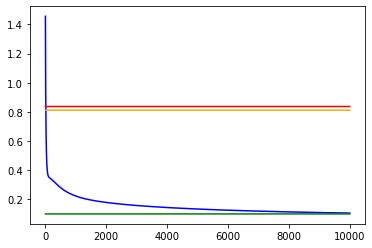

In [11]:
# features chosen by-hand

epochs=10000


def log_m2(frame):
    """log of flat size (mse gives negative values to number of bathrooms and bedrooms,
    possibly due to the fact that for especially big flats avg_price*area
    overestimates the price)"""
    
    return frame.assign(**{
        'logm2': lambda m:np.log(np.array(m.m2)),
        'm2_logm2': lambda m:np.log(np.array(m.m2)) * np.array(m.m2),
    })


def avg_district(frame):
    """to capture the fact that avg. price per m2 in different districts of the city might be different"""
    district_dummies = pandas.get_dummies(frame['dzielnica'])
    frame = frame.assign(**{
        '{}_avg'.format(col): np.array(district_dummies[col]) * np.array(frame.m2)
        for col in district_dummies.columns
        if col != 'ochotowo'  # reference column (otherwise they would be lineary dependent)
    })
    frame = frame.drop(columns='dzielnica')
    return frame


def prepare_df(frame):
    frame = log_m2(frame)
    frame = avg_district(frame)
    frame = frame.assign(
        lazienki_i_sypialnie=lambda m: np.array(m['ilość_sypialni']) * np.array(m['ilość_łazienek'])
    )
    return frame

ms_f = pandas.read_csv('mieszkania.csv')
ms_f = prepare_df(ms_f)
ms_f_p = PrepData(ms_f, 'cena', [])

msle_f = LRGradDesc(ms_f_p, msle, Gradient.get('msle'))
msle_fr = msle_f.train(epochs, 0.005, ws=[0.] * ms_f_p.m)
msle_fr.plot(color='blue')

mse_f = LRGradDesc(ms_f_p, mse, Gradient.get('mse'))
mse_fr = mse_f.train(epochs, 0.3)

# msle optimized with explicit formula for mse (fitting linear model to log(1+yi))
ms_f_log = PrepData(ms_f, 'cena', [], log_ys=True)
msle_f_exact = ExactMSEReg(ms_f_log).train()
plt.plot([msle_f_exact.error(mse)] * epochs, color='green')

print(msle_fr.train_error(), msle_fr.error(mse), mse_fr.error(msle), mse_fr.error(mse), msle_f_exact.error(mse), "\n")

ms_f_t = pandas.read_csv('mieszkania_test.csv')
ms_f_t = prepare_df(ms_f_t)
msle_fr_t = msle_fr.test_error(msle, ms_f_t)
plt.plot([msle_fr_t] * epochs, color='orange')
msle_f_exact_t = msle_f_exact.test_error(mse, ms_f_t)
plt.plot([msle_f_exact_t] * epochs, color='red')
print(msle_fr_t, msle_f_exact_t, "\n")

for ((c, dw), (_, mw), (_, ew)) in zip(msle_fr.coefs(), mse_fr.coefs(), msle_f_exact.coefs()):
    print (c, dw, mw, ew)
